# Heart diseases prediction
# Predict a risk of heart failure

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

from catboost import CatBoostClassifier
from catboost import Pool, cv

In [2]:
plt.style.use('dark_background')

### Load data

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


In [5]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,30000.0,50062.686900,28906.167148,5.0,24983.25,49995.5,75232.25,99997.0
age,30000.0,19455.528400,2477.840922,8865.0,17658.00,19694.0,21320.00,23705.0
gender,30000.0,1.353733,0.478136,1.0,1.00,1.0,2.00,2.0
height,30000.0,164.322267,8.213740,50.0,159.00,165.0,170.00,198.0
weight,30000.0,74.120615,14.341540,10.0,65.00,72.0,82.00,183.0
ap_hi,30000.0,130.271300,212.501152,-130.0,120.00,120.0,140.00,16020.0
ap_lo,30000.0,95.689000,163.852598,-90.0,80.00,80.0,90.00,9100.0
cholesterol,30000.0,1.368033,0.679166,1.0,1.00,1.0,2.00,3.0
gluc,30000.0,1.222700,0.566494,1.0,1.00,1.0,1.00,3.0
smoke,30000.0,0.088600,0.284170,0.0,0.00,0.0,0.00,1.0


In [6]:
train['age_year'] = round(train.age / 365, 1)

In [7]:
test['age_year']  = round(test.age / 365, 1)

In [8]:
train = train.drop('id', axis=1)

In [9]:
train.isna().mean()

age            0.0
gender         0.0
height         0.0
weight         0.0
ap_hi          0.0
ap_lo          0.0
cholesterol    0.0
gluc           0.0
smoke          0.0
alco           0.0
active         0.0
cardio         0.0
age_year       0.0
dtype: float64

In [10]:
train.loc[train.ap_hi > 2000, 'ap_hi'] = train.ap_hi / 100

In [11]:
test.loc[test.ap_hi > 2000, 'ap_hi'] = test.ap_hi / 100

In [12]:
train.loc[train.ap_hi > 800, 'ap_hi'] = train.ap_hi / 10

In [13]:
test.loc[test.ap_hi > 800, 'ap_hi'] = test.ap_hi / 10

In [14]:
train = train.loc[~(train.ap_hi > 300)]

In [15]:
train.loc[train.ap_hi < 0, 'ap_hi'] = train.ap_hi *-1

In [16]:
test.loc[test.ap_hi < 0, 'ap_hi'] = test.ap_hi *-1

In [17]:
train.loc[train.ap_hi <= 50, 'ap_hi'] = train.ap_hi *10

In [18]:
test.loc[test.ap_hi <= 50, 'ap_hi'] = test.ap_hi *10

In [19]:
train.loc[train.ap_hi <= 75]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year
636,20457,2,169,68.0,70.0,110,1,1,0,0,1,0,56.0
4830,16969,2,159,68.0,70.0,100,1,1,0,0,0,0,46.5
5382,21240,1,162,69.0,70.0,80,1,1,0,0,1,0,58.2
7076,21235,1,154,61.0,70.0,50,2,2,0,1,0,0,58.2
8757,16905,2,163,63.0,10.0,2088,1,1,1,0,1,0,46.3
11951,15795,2,160,52.0,70.0,40,1,1,1,0,1,0,43.3
13675,21298,1,156,72.0,70.0,110,3,3,0,0,1,1,58.4
13755,15892,1,157,73.0,60.0,40,1,3,0,0,0,0,43.5
14269,23341,1,167,77.0,70.0,110,1,1,0,0,0,0,63.9
16629,14506,1,162,57.0,70.0,50,1,1,0,0,1,0,39.7


In [20]:
train.loc[train.ap_lo < 0, 'ap_lo'] = train.ap_lo * -1

In [21]:
test.loc[test.ap_lo < 0, 'ap_lo'] = test.ap_lo * -1

In [22]:
train = train.loc[~(train.ap_lo == 0)]

In [23]:
train.loc[train.ap_lo <= 1, 'ap_lo'] = train.ap_lo * 100

In [24]:
test.loc[test.ap_lo <= 1, 'ap_lo'] = test.ap_lo * 100

In [25]:
train.loc[train.ap_lo <= 10, 'ap_lo'] = train.ap_lo * 10

In [26]:
test.loc[test.ap_lo <= 10, 'ap_lo'] = test.ap_lo * 10

In [27]:
train.loc[train.ap_lo > 5000, 'ap_lo'] = train.ap_lo / 100

In [28]:
test.loc[test.ap_lo > 5000, 'ap_lo'] = test.ap_lo / 100

In [29]:
train.loc[train.ap_lo > 500, 'ap_lo'] = train.ap_lo / 10

In [30]:
test.loc[test.ap_lo > 500, 'ap_lo'] = test.ap_lo / 10

In [31]:
train['ap_lo_buff'] = train.ap_lo
train.loc[train.ap_lo > train.ap_hi, 'ap_lo_buff'] = train.ap_hi
train.loc[train.ap_lo > train.ap_hi, 'ap_hi'] = train.ap_lo
train.ap_lo = train.ap_lo_buff
train= train.drop('ap_lo_buff', axis=1)

In [32]:
test['ap_lo_buff'] = test.ap_lo
test.loc[test.ap_lo > test.ap_hi, 'ap_lo_buff'] = test.ap_hi
test.loc[test.ap_lo > test.ap_hi, 'ap_hi'] = test.ap_lo
test.ap_lo = test.ap_lo_buff
test= test.drop('ap_lo_buff', axis=1)

In [33]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,69977.0,19468.874645,2467.159666,10798.0,17664.0,19703.0,21327.0,23713.0
gender,69977.0,1.349543,0.476829,1.0,1.0,1.0,2.0,2.0
height,69977.0,164.359375,8.210252,55.0,159.0,165.0,170.0,250.0
weight,69977.0,74.207487,14.395354,10.0,65.0,72.0,82.0,200.0
ap_hi,69977.0,127.071213,17.055950,60.0,120.0,120.0,140.0,240.0
ap_lo,69977.0,81.570664,9.805289,10.0,80.0,80.0,90.0,182.0
cholesterol,69977.0,1.366906,0.680271,1.0,1.0,1.0,2.0,3.0
gluc,69977.0,1.226474,0.572272,1.0,1.0,1.0,1.0,3.0
smoke,69977.0,0.088129,0.283484,0.0,0.0,0.0,0.0,1.0
alco,69977.0,0.053775,0.225574,0.0,0.0,0.0,0.0,1.0


In [34]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,30000.0,50062.686900,28906.167148,5.0,24983.25,49995.5,75232.25,99997.0
age,30000.0,19455.528400,2477.840922,8865.0,17658.00,19694.0,21320.00,23705.0
gender,30000.0,1.353733,0.478136,1.0,1.00,1.0,2.00,2.0
height,30000.0,164.322267,8.213740,50.0,159.00,165.0,170.00,198.0
weight,30000.0,74.120615,14.341540,10.0,65.00,72.0,82.00,183.0
ap_hi,30000.0,127.134563,17.371187,30.0,120.00,120.0,140.00,509.0
ap_lo,30000.0,81.589887,9.837081,0.0,80.00,80.0,90.00,172.0
cholesterol,30000.0,1.368033,0.679166,1.0,1.00,1.0,2.00,3.0
gluc,30000.0,1.222700,0.566494,1.0,1.00,1.0,1.00,3.0
smoke,30000.0,0.088600,0.284170,0.0,0.00,0.0,0.00,1.0


<AxesSubplot:>

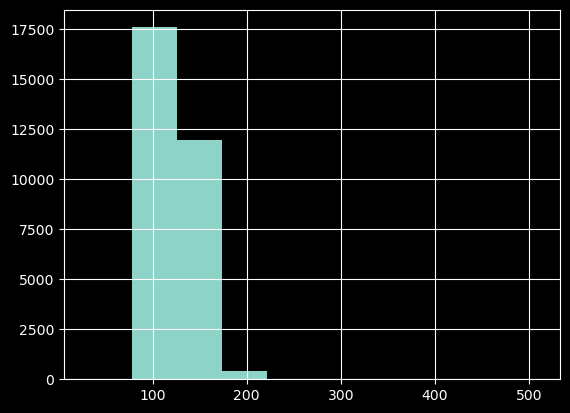

In [35]:
test.ap_hi.hist()

In [36]:
test.loc[test.ap_hi < 50, 'ap_hi'] = test.ap_hi *10

In [37]:
test.loc[test.ap_hi > 200, 'ap_hi'] = 200

In [38]:
train.loc[train.ap_lo > 150]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year
4781,18961,1,158,74.0,200.0,170.0,1,1,0,0,1,1,51.9
4981,22722,2,173,74.0,220.0,160.0,2,2,0,0,1,1,62.3
31315,22801,1,163,115.0,200.0,170.0,1,1,0,0,1,1,62.5
38022,21770,1,161,84.0,196.0,182.0,2,2,0,0,1,1,59.6
43998,22652,2,163,70.0,200.0,180.0,1,1,0,0,0,1,62.1
49303,22045,1,157,86.0,190.0,170.0,2,2,0,1,1,1,60.4
54987,19491,1,169,80.0,200.0,160.0,3,3,0,0,1,0,53.4


In [39]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,69977.0,19468.874645,2467.159666,10798.0,17664.0,19703.0,21327.0,23713.0
gender,69977.0,1.349543,0.476829,1.0,1.0,1.0,2.0,2.0
height,69977.0,164.359375,8.210252,55.0,159.0,165.0,170.0,250.0
weight,69977.0,74.207487,14.395354,10.0,65.0,72.0,82.0,200.0
ap_hi,69977.0,127.071213,17.055950,60.0,120.0,120.0,140.0,240.0
ap_lo,69977.0,81.570664,9.805289,10.0,80.0,80.0,90.0,182.0
cholesterol,69977.0,1.366906,0.680271,1.0,1.0,1.0,2.0,3.0
gluc,69977.0,1.226474,0.572272,1.0,1.0,1.0,1.0,3.0
smoke,69977.0,0.088129,0.283484,0.0,0.0,0.0,0.0,1.0
alco,69977.0,0.053775,0.225574,0.0,0.0,0.0,0.0,1.0


In [40]:
train.loc[train.ap_lo < 20, 'ap_lo'] = train.ap_lo * 10

In [41]:
train.loc[train.ap_lo < 45]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year
418,16658,1,157,72.0,150.0,30.0,1,1,0,0,1,1,45.6
507,16822,1,165,64.0,140.0,40.0,1,1,0,0,1,1,46.1
5333,20984,1,164,102.0,120.0,30.0,2,1,0,0,1,0,57.5
8797,21155,1,162,68.0,110.0,20.0,1,1,0,0,1,0,58.0
10645,20343,1,160,65.0,130.0,40.0,3,1,0,0,0,1,55.7
11820,18171,1,169,69.0,128.0,20.0,1,1,0,0,1,1,49.8
11951,15795,2,160,52.0,70.0,40.0,1,1,1,0,1,0,43.3
12997,22627,1,158,67.0,140.0,40.0,1,1,0,0,1,1,62.0
13755,15892,1,157,73.0,60.0,40.0,1,3,0,0,0,0,43.5
13935,18007,1,164,74.0,110.0,20.0,1,1,0,0,1,0,49.3


### Age

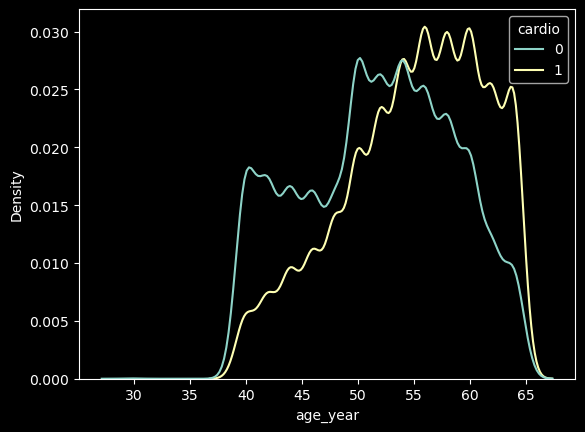

In [42]:
sns.kdeplot(data=train, x='age_year', hue='cardio')
None

In [43]:
train = train.loc[~(train.age_year < 35)]

### Height

In [44]:
train = train.loc[train['height'] != 250]

In [45]:
train = train.loc[~(train['height'] < 130)]

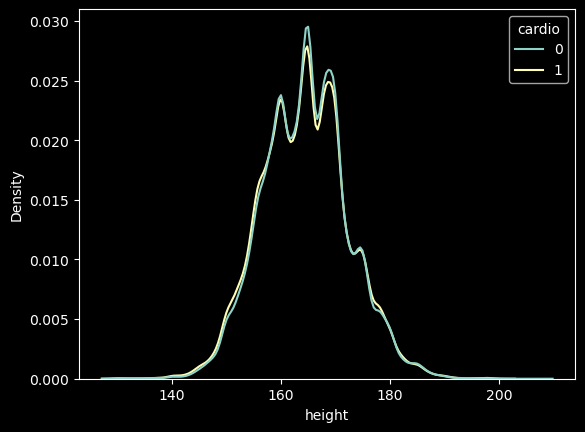

In [46]:
sns.kdeplot(data=train, x='height', hue='cardio')
None

In [47]:
train.drop(train[(train['height'] > train['height'].quantile(0.975)) | (train['height'] < train['height'].quantile(0.025))].index,inplace=True)
train.drop(train[(train['weight'] > train['weight'].quantile(0.975)) | (train['weight'] < train['weight'].quantile(0.025))].index,inplace=True)

### Weight

In [48]:
train.loc[train.weight < 30, 'weight'] = train.weight.median()

In [49]:
test.loc[test.weight < 30, 'weight'] = test.weight.median()

In [50]:
train = train.loc[~(train['weight'] > 140)]

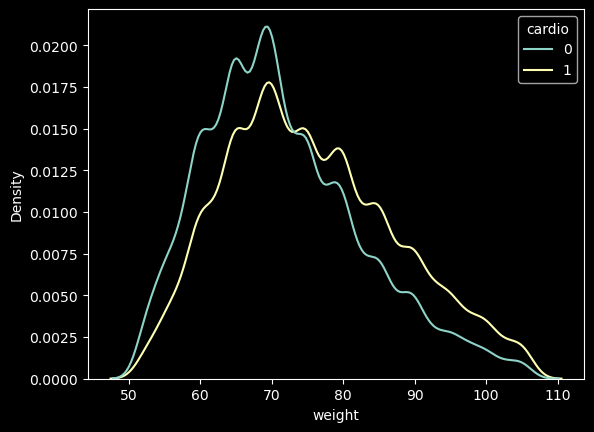

In [51]:
sns.kdeplot(data=train, x='weight', hue='cardio')
None

### ap_hi

In [52]:
train = train.loc[~(train.ap_hi < 85)]

In [53]:
train = train.loc[~(train.ap_hi > 190)]

<AxesSubplot:xlabel='ap_hi', ylabel='Density'>

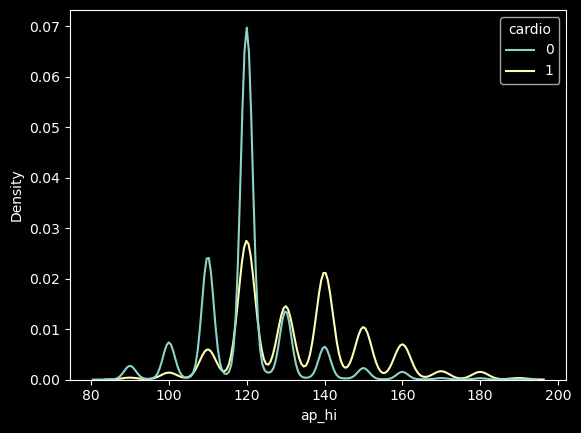

In [54]:
sns.kdeplot(data=train, x='ap_hi', hue='cardio')

In [55]:
# Create multiple group using lamda function

def ap (values):

    if values<=120:

        return 1

    elif 120<values<=200:

        return 2

    else:

        return 3

train['ap_hi_group'] = train.ap_hi.apply(lambda x: ap(x))
test['ap_hi_group'] = test.ap_hi.apply(lambda x: ap(x))

### ap_lo

In [56]:
train = train.loc[~(train.ap_lo < 50)]

In [57]:
train = train.loc[~(train.ap_lo > 120)]

<AxesSubplot:xlabel='ap_lo', ylabel='Density'>

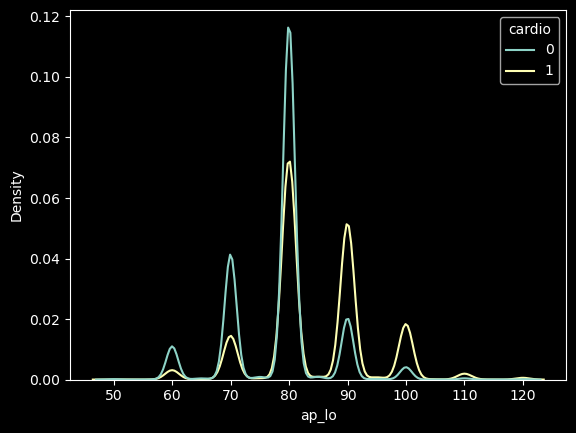

In [58]:
sns.kdeplot(data=train, x='ap_lo', hue='cardio')

In [59]:
# Create multiple group using lamda function

def aplow (values):

    if values<=50:

        return 1

    elif 50<values<=85:

        return 2

    else:

        return 3

train['ap_lo_group'] = train.ap_lo.apply(lambda x: aplow(x))
test['ap_lo_group'] = test.ap_lo.apply(lambda x: aplow(x))

## Feature engineering

### BMI

In [60]:
train['bmi'] = np.round(train.weight / ((train.height / 100) ** 2), 1)
test['bmi'] = np.round(test.weight / ((test.height / 100) ** 2), 1)

In [61]:
train = train.loc[~(train.bmi > 45)]

In [62]:
train = train.loc[~(train.bmi < 15)]

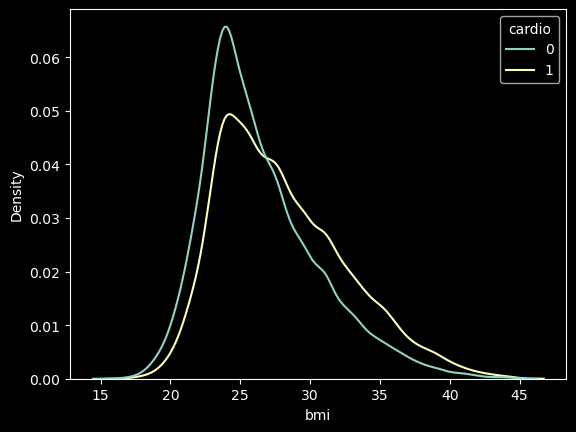

In [63]:
sns.kdeplot(data=train, x='bmi', hue='cardio')
None

### BMI groups

In [64]:
train.loc[train.bmi <= 18.5, 'bmi_group'] = 1
train.loc[(train.bmi > 18.5) & (train.bmi <= 25), 'bmi_group'] = 2
train.loc[(train.bmi > 25) & (train.bmi <= 30), 'bmi_group'] = 3
train.loc[train.bmi > 30, 'bmi_group'] = 4

In [65]:
test.loc[test.bmi <= 18.5, 'bmi_group'] = 1
test.loc[(test.bmi > 18.5) & (test.bmi <= 25), 'bmi_group'] = 2
test.loc[(test.bmi > 25) & (test.bmi <= 30), 'bmi_group'] = 3
test.loc[test.bmi > 30, 'bmi_group'] = 4

### Older 55

In [66]:
train['older_55'] = np.where(train.age_year > 55, 1, 0)

In [67]:
test['older_55'] = np.where(test.age_year > 55, 1, 0)

### AP

In [68]:
train['s_d_ratio'] = np.round(train['ap_hi']/train['ap_lo'],2)

train['s_d_diff'] = np.round(train['ap_hi']-train['ap_lo'],2)

In [69]:
test['s_d_ratio'] = np.round(test['ap_hi']/test['ap_lo'],2)

test['s_d_diff'] = np.round(test['ap_hi']-test['ap_lo'],2)

In [70]:
train['s_d_diff_above_45'] = np.where(train['s_d_diff']>45,1,0)

train['ap_lo_above_85'] = np.where(train['ap_lo']>85,1,0)

train['ap_hi_above_125'] = np.where(train['ap_hi']>125,1,0)

In [71]:
test['s_d_diff_above_45'] = np.where(test['s_d_diff']>45,1,0)

test['ap_lo_above_85'] = np.where(test['ap_lo']>85,1,0)

test['ap_hi_above_125'] = np.where(test['ap_hi']>125,1,0)

In [72]:
train = train.loc[~(train.bmi > 45)]

In [73]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,30000.0,5.006269e+04,28906.167148,5.0,24983.25,49995.5,75232.25,99997.0
age,30000.0,1.945553e+04,2477.840922,8865.0,17658.00,19694.0,21320.00,23705.0
gender,30000.0,1.353733e+00,0.478136,1.0,1.00,1.0,2.00,2.0
height,30000.0,1.643223e+02,8.213740,50.0,159.00,165.0,170.00,198.0
weight,30000.0,7.413030e+01,14.320360,30.0,65.00,72.0,82.00,183.0
ap_hi,30000.0,1.270959e+02,16.926008,76.0,120.00,120.0,140.00,200.0
ap_lo,30000.0,8.158989e+01,9.837081,0.0,80.00,80.0,90.00,172.0
cholesterol,30000.0,1.368033e+00,0.679166,1.0,1.00,1.0,2.00,3.0
gluc,30000.0,1.222700e+00,0.566494,1.0,1.00,1.0,1.00,3.0
smoke,30000.0,8.860000e-02,0.284170,0.0,0.00,0.0,0.00,1.0


In [74]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,63577.0,19471.985278,2461.361453,14275.0,17677.0,19705.0,21323.00,23713.0
gender,63577.0,1.347516,0.476185,1.0,1.0,1.0,2.00,2.0
height,63577.0,164.501235,6.857146,150.0,160.0,165.0,169.00,180.0
weight,63577.0,73.522276,11.703913,52.0,65.0,72.0,81.00,106.0
ap_hi,63577.0,126.742017,16.171707,85.0,120.0,120.0,140.00,190.0
ap_lo,63577.0,81.464984,9.320673,50.0,80.0,80.0,90.00,120.0
cholesterol,63577.0,1.358227,0.674342,1.0,1.0,1.0,1.00,3.0
gluc,63577.0,1.222234,0.568718,1.0,1.0,1.0,1.00,3.0
smoke,63577.0,0.086148,0.280584,0.0,0.0,0.0,0.00,1.0
alco,63577.0,0.052771,0.223577,0.0,0.0,0.0,0.00,1.0


## Model

In [75]:
train.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'age_year', 'ap_hi_group',
       'ap_lo_group', 'bmi', 'bmi_group', 'older_55', 's_d_ratio', 's_d_diff',
       's_d_diff_above_45', 'ap_lo_above_85', 'ap_hi_above_125'],
      dtype='object')

In [76]:
train.nunique().sort_values(ascending=False)

age                  8006
bmi                   278
age_year              259
weight                168
s_d_diff              152
s_d_ratio             151
ap_hi                 106
ap_lo                  95
height                 31
bmi_group               4
cholesterol             3
gluc                    3
ap_lo_group             3
ap_lo_above_85          2
s_d_diff_above_45       2
older_55                2
cardio                  2
ap_hi_group             2
gender                  2
active                  2
alco                    2
smoke                   2
ap_hi_above_125         2
dtype: int64

In [77]:
features = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
            'gluc', 'smoke', 'alco', 'active', 'age_year', 'bmi']

In [78]:
cat_features = ['gender', 'cholesterol',
                'gluc', 'smoke', 'alco', 'active']

In [79]:
X = train[features]
y = train.cardio

In [80]:
#train.bmi_group = train.bmi_group.astype('int')

In [81]:
#train.bmi = train.bmi.astype('int')dd

In [82]:
#train.age_year = train.age_year.astype('int')

In [83]:
train[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63577 entries, 0 to 69999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   gender       63577 non-null  int64
 1   cholesterol  63577 non-null  int64
 2   gluc         63577 non-null  int64
 3   smoke        63577 non-null  int64
 4   alco         63577 non-null  int64
 5   active       63577 non-null  int64
dtypes: int64(6)
memory usage: 3.4 MB


In [84]:
# Разделение на тренировочно-валидационную и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  random_state=42, 
                                                  test_size=.25)

In [85]:
model = CatBoostClassifier(learning_rate=0.015,
                           early_stopping_rounds=200,
                           verbose=100,
                           cat_features=cat_features,
                           random_state=42,
                           auto_class_weights='Balanced',
                           eval_metric='AUC')

In [86]:
model.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	test: 0.7745128	best: 0.7745128 (0)	total: 195ms	remaining: 3m 15s
100:	test: 0.7948210	best: 0.7948210 (100)	total: 4.39s	remaining: 39.1s
200:	test: 0.7978466	best: 0.7978527 (199)	total: 8.04s	remaining: 32s
300:	test: 0.7989123	best: 0.7989123 (300)	total: 11.5s	remaining: 26.6s
400:	test: 0.7992837	best: 0.7992895 (399)	total: 16.1s	remaining: 24s
500:	test: 0.7994972	best: 0.7994972 (500)	total: 19.6s	remaining: 19.5s
600:	test: 0.7995894	best: 0.7995894 (600)	total: 22.9s	remaining: 15.2s
700:	test: 0.7997003	best: 0.7997003 (700)	total: 26.4s	remaining: 11.2s
800:	test: 0.7998040	best: 0.7998040 (800)	total: 29.9s	remaining: 7.42s
900:	test: 0.7997913	best: 0.7998275 (833)	total: 33.5s	remaining: 3.68s
999:	test: 0.7998022	best: 0.7998275 (833)	total: 37.4s	remaining: 0us

bestTest = 0.7998275293
bestIteration = 833

Shrink model to first 834 iterations.


In [87]:
fi = pd.DataFrame({'w':model.feature_importances_, 'name':X_train.columns})
fi.sort_values('w', ascending=False)

,w,name
4,38.250906,ap_hi
6,14.336186,cholesterol
11,11.589809,age_year
0,10.159279,age
5,4.988552,ap_lo
3,4.196862,weight
7,3.986697,gluc
12,3.932923,bmi
10,2.496752,active
2,2.206039,height


In [88]:
y_pred = model.predict_proba(test[features])[:,1]
pd.Series(y_pred)

0        0.499177
1        0.546857
2        0.414815
3        0.554104
4        0.213359
           ...   
29995    0.872854
29996    0.187655
29997    0.448826
29998    0.285758
29999    0.702679
Length: 30000, dtype: float64

### Save model

In [89]:
model.save_model('models/model_cbc',
                 format="cbm",
                 export_parameters=None,
                 pool=None)

## Sub

In [90]:
sub = pd.DataFrame()
sub['id'] = test['id']
sub['cardio'] = pd.Series(y_pred)
sub

,id,cardio
0,5,0.499177
1,6,0.546857
2,7,0.414815
3,10,0.554104
4,11,0.213359
...,...,...
29995,99984,0.872854
29996,99987,0.187655
29997,99989,0.448826
29998,99994,0.285758


In [92]:
sub.to_csv('sub/sub9.csv', index=False)